In [16]:

# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io

# Seeds
torch.manual_seed(123456)
np.random.seed(123456)

# --- Definition for the Morlet Wavelet Activation Function ---
class Morlet(nn.Module):
    """
    Morlet Wavelet Activation Function.
    A non-linear activation function defined as exp(-x^2/2) * cos(5x).
    """
    def __init__(self):
        super(Morlet, self).__init__()

    def forward(self, x):
        return torch.exp(-0.5 * x**2) * torch.cos(5 * x)

# --- Generate Neural Network (Modified to use Morlet) ---
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))
        self.net.add_module('Morlet_layer_1', Morlet())

        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))
            self.net.add_module('Morlet_layer_%d' % (num), Morlet())
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))

    def forward(self, x):
        return self.net(x)

    # Loss function for PDE (Unchanged from original code)
    def loss_pde(self, x):
        y = self.net(x)
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4

        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]

        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]

        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]

        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    # Loss function for initial condition (Unchanged from original code)
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]

        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn- rho_ic) ** 2).mean()  + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

# --- Helper Functions (Unchanged) ---
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))
    u_init = np.zeros((x.shape[0]))
    p_init = np.zeros((x.shape[0]))

    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1
    return rho_init, u_init, p_init

# --- Main Training Function (Now with Optimized Loop) ---
def main():
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    lr = 0.0005
    num_x = 1000
    num_t = 1000
    num_i_train = 1000
    epochs = 76140
    num_f_train = 11000
    x = np.linspace(-1.5, 3.125, num_x)
    t = np.linspace(0, 0.2, num_t)
    t_grid, x_grid = np.meshgrid(t, x)
    T = t_grid.flatten()[:, None]
    X = x_grid.flatten()[:, None]

    id_ic = np.random.choice(num_x, num_i_train, replace=False)
    id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

    x_ic = x_grid[id_ic, 0][:, None]
    t_ic = t_grid[id_ic, 0][:, None]
    x_ic_train = np.hstack((t_ic, x_ic))
    rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)

    x_int = X[:, 0][id_f, None]
    t_int = T[:, 0][id_f, None]
    x_int_train = np.hstack((t_int, x_int))
    x_test = np.hstack((T, X))

    # Generate tensors and move to the selected device
    x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
    x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
    u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
    p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- OPTIMIZED TRAINING LOOP ---
    print('Start training with Morlet Activation...')
    tic = time.time()
    for epoch in range(1, epochs + 1):
        model.train()

        # The closure function calculates the loss and gradients
        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(x_int_train)
            loss_ic = model.loss_ic(x_ic_train, rho_ic_train, u_ic_train, p_ic_train)
            # Weighted loss function from the paper
            loss = 0.1 * loss_pde + 10 * loss_ic
            loss.backward()
            # Return all loss components for logging
            return loss, loss_pde, loss_ic

        # Update model weights
        loss, loss_pde, loss_ic = optimizer.step(closure)

        # OPTIMIZATION: Print progress only every 1000 epochs to avoid I/O bottleneck
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f} | '
                  f'PDE Loss: {loss_pde.item():.8f} | IC Loss: {loss_ic.item():.8f}')

    toc = time.time()
    print(f'Total training time: {toc - tic:.2f} seconds')

    # Evaluate on the whole computational domain
    u_pred = to_numpy(model(x_test))
    # Save with a new name to distinguish from the original
    scipy.io.savemat('Sod_Shock_Tube_Morlet_Optimized.mat',
                     {'x': x, 't': t, 'rho': u_pred[:,0], 'u': u_pred[:,2], 'p': u_pred[:,1]})
    print("Saved results to Sod_Shock_Tube_Morlet_Optimized.mat")

if __name__ == '__main__':
    main()

Using device: cuda
Start training with Morlet Activation...
Epoch 1000/76140 | Total Loss: 0.154678 | PDE Loss: 1.21476889 | IC Loss: 0.00332016
Epoch 2000/76140 | Total Loss: 0.052814 | PDE Loss: 0.34832686 | IC Loss: 0.00179816
Epoch 3000/76140 | Total Loss: 0.032189 | PDE Loss: 0.18285477 | IC Loss: 0.00139039
Epoch 4000/76140 | Total Loss: 0.022132 | PDE Loss: 0.11210783 | IC Loss: 0.00109211
Epoch 5000/76140 | Total Loss: 0.016872 | PDE Loss: 0.08493462 | IC Loss: 0.00083788
Epoch 6000/76140 | Total Loss: 0.011259 | PDE Loss: 0.05075432 | IC Loss: 0.00061839
Epoch 7000/76140 | Total Loss: 0.011285 | PDE Loss: 0.06100026 | IC Loss: 0.00051845
Epoch 8000/76140 | Total Loss: 0.009522 | PDE Loss: 0.05334234 | IC Loss: 0.00041875
Epoch 9000/76140 | Total Loss: 0.005729 | PDE Loss: 0.03326671 | IC Loss: 0.00024026
Epoch 10000/76140 | Total Loss: 0.004171 | PDE Loss: 0.02735859 | IC Loss: 0.00014347
Epoch 11000/76140 | Total Loss: 0.003230 | PDE Loss: 0.02141773 | IC Loss: 0.00010886
Epo

File loaded successfully. Variables found: dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'rho', 'u', 'p'])


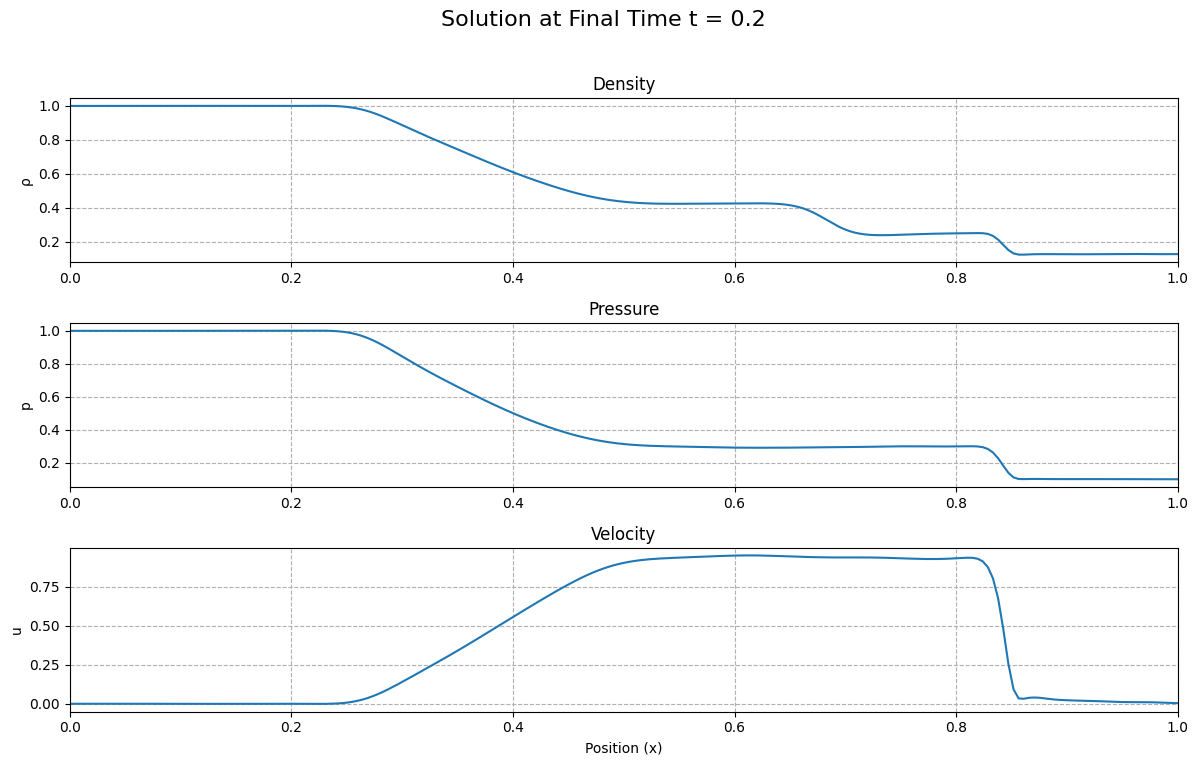

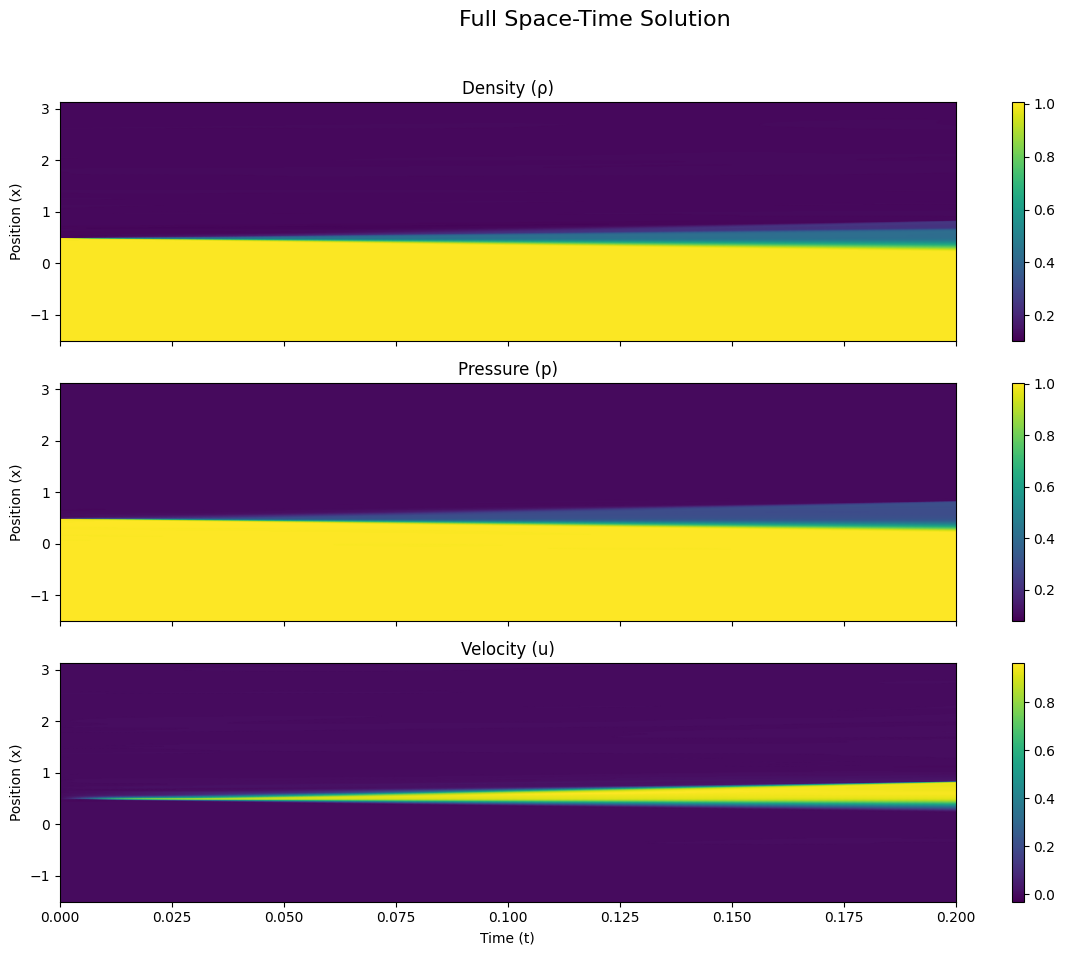

In [17]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# --- Load the .mat file ---
# The loadmat function returns a Python dictionary
try:
    data = scipy.io.loadmat('Sod_Shock_Tube_Morlet_Optimized.mat')
    print("File loaded successfully. Variables found:", data.keys())
except FileNotFoundError:
    print("Error: The .mat file was not found. Make sure the training script has finished.")
    exit()

# --- Extract the data from the dictionary ---
# The data is saved as flattened 1D arrays, so we need the original dimensions
num_x = 1000
num_t = 1000
x = data['x'].flatten()
t = data['t'].flatten()

# Reshape the 1D predicted arrays back into a 2D grid (space x time)
rho = data['rho'].reshape(num_x, num_t)
p = data['p'].reshape(num_x, num_t)
u = data['u'].reshape(num_x, num_t)


# --- 1. Plot the Solution at the Final Time (t=0.2) ---
# This recreates the 1D plots shown in the paper (e.g., Figure 5, left side)

plt.figure(figsize=(12, 8))
plt.suptitle('Solution at Final Time t = 0.2', fontsize=16)

# Density Plot
plt.subplot(3, 1, 1)
plt.plot(x, rho[:, -1]) # Plot the last time-step
plt.title('Density')
plt.ylabel('ρ')
plt.xlim(0, 1) # Show the original physical domain
plt.grid(True, linestyle='--')

# Pressure Plot
plt.subplot(3, 1, 2)
plt.plot(x, p[:, -1])
plt.title('Pressure')
plt.ylabel('p')
plt.xlim(0, 1)
plt.grid(True, linestyle='--')

# Velocity Plot
plt.subplot(3, 1, 3)
plt.plot(x, u[:, -1])
plt.title('Velocity')
plt.ylabel('u')
plt.xlabel('Position (x)')
plt.xlim(0, 1)
plt.grid(True, linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- 2. Plot the Full Space-Time Solution (Heatmap) ---
# This recreates the 2D overview plots shown in the paper (e.g., Figure 5, right side)

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Full Space-Time Solution', fontsize=16)

# Density Heatmap
im1 = axs[0].pcolormesh(t, x, rho, shading='gouraud', cmap='viridis')
axs[0].set_title('Density (ρ)')
axs[0].set_ylabel('Position (x)')
fig.colorbar(im1, ax=axs[0])

# Pressure Heatmap
im2 = axs[1].pcolormesh(t, x, p, shading='gouraud', cmap='viridis')
axs[1].set_title('Pressure (p)')
axs[1].set_ylabel('Position (x)')
fig.colorbar(im2, ax=axs[1])

# Velocity Heatmap
im3 = axs[2].pcolormesh(t, x, u, shading='gouraud', cmap='viridis')
axs[2].set_title('Velocity (u)')
axs[2].set_ylabel('Position (x)')
axs[2].set_xlabel('Time (t)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [24]:
# --- Step 0: Install and Import Libraries ---
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# --- Step 1: Definitions and Setup ---
# Set seeds for reproducibility
torch.manual_seed(123456)
np.random.seed(123456)

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Morlet(nn.Module):
    def __init__(self):
        super(Morlet, self).__init__()
    def forward(self, x):
        return torch.exp(-0.5 * x**2) * torch.cos(5 * x)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))
        self.net.add_module('Morlet_layer_1', Morlet())
        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))
            self.net.add_module('Morlet_layer_%d' % (num), Morlet())
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init = np.zeros((x_coords.shape[0]))
    u_init = np.zeros((x_coords.shape[0]))
    p_init = np.zeros((x_coords.shape[0]))
    for i in range(N):
        if (x_coords[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1
    return rho_init, u_init, p_init

# --- Step 2: Data Generation and Model Training ---
# Parameters
lr = 0.0005
num_x = 1000
num_t = 1000
num_i_train = 1000
epochs = 77000
num_f_train = 11000

# Create domain and test data
x_domain = np.linspace(-1.5, 3.125, num_x)
t_domain = np.linspace(0, 0.2, num_t)
t_grid, x_grid = np.meshgrid(t_domain, x_domain)
T = t_grid.flatten()[:, None]
X = x_grid.flatten()[:, None]
x_test = np.hstack((T, X))
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

# Create training data
id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
x_ic = x_grid[id_ic, 0][:, None]
t_ic = t_grid[id_ic, 0][:, None]
x_ic_train = np.hstack((t_ic, x_ic))
rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)
x_int = X[id_f, 0][:, None]
t_int = T[id_f, 0][:, None]
x_int_train = np.hstack((t_int, x_int))

# Move training data to device
x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

# Initialize model and optimizer
model = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# --- THE TRAINING LOOP ---
print('Start training with Morlet Activation...')
tic = time.time()
for epoch in range(1, epochs + 1):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(x_int_train_tensor)
        loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
        loss = 0.1 * loss_pde + 10 * loss_ic
        loss.backward()
        return loss, loss_pde, loss_ic

    loss, loss_pde, loss_ic = optimizer.step(closure)

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f} | '
              f'PDE Loss: {loss_pde.item():.8f} | IC Loss: {loss_ic.item():.8f}')

toc = time.time()
print(f'\nTotal training time: {toc - tic:.2f} seconds')
print("\n--- Training Complete. You can now run the next cell for analysis. ---")

Using device: cuda
Start training with Morlet Activation...
Epoch 1000/77000 | Total Loss: 0.154678 | PDE Loss: 1.21476889 | IC Loss: 0.00332016
Epoch 2000/77000 | Total Loss: 0.052814 | PDE Loss: 0.34832686 | IC Loss: 0.00179816
Epoch 3000/77000 | Total Loss: 0.032189 | PDE Loss: 0.18285477 | IC Loss: 0.00139039
Epoch 4000/77000 | Total Loss: 0.022132 | PDE Loss: 0.11210783 | IC Loss: 0.00109211
Epoch 5000/77000 | Total Loss: 0.016872 | PDE Loss: 0.08493462 | IC Loss: 0.00083788
Epoch 6000/77000 | Total Loss: 0.011259 | PDE Loss: 0.05075432 | IC Loss: 0.00061839
Epoch 7000/77000 | Total Loss: 0.011285 | PDE Loss: 0.06100026 | IC Loss: 0.00051845
Epoch 8000/77000 | Total Loss: 0.009522 | PDE Loss: 0.05334234 | IC Loss: 0.00041875
Epoch 9000/77000 | Total Loss: 0.005729 | PDE Loss: 0.03326671 | IC Loss: 0.00024026
Epoch 10000/77000 | Total Loss: 0.004171 | PDE Loss: 0.02735859 | IC Loss: 0.00014347
Epoch 11000/77000 | Total Loss: 0.003230 | PDE Loss: 0.02141773 | IC Loss: 0.00010886
Epo


--- Evaluating Final Model and Calculating L2 Error ---

--- Final Results ---
Relative L2 Error (Density): 3.5803e-02
Relative L2 Error (Pressure): 3.9689e-02
Relative L2 Error (Velocity): 1.4270e-01


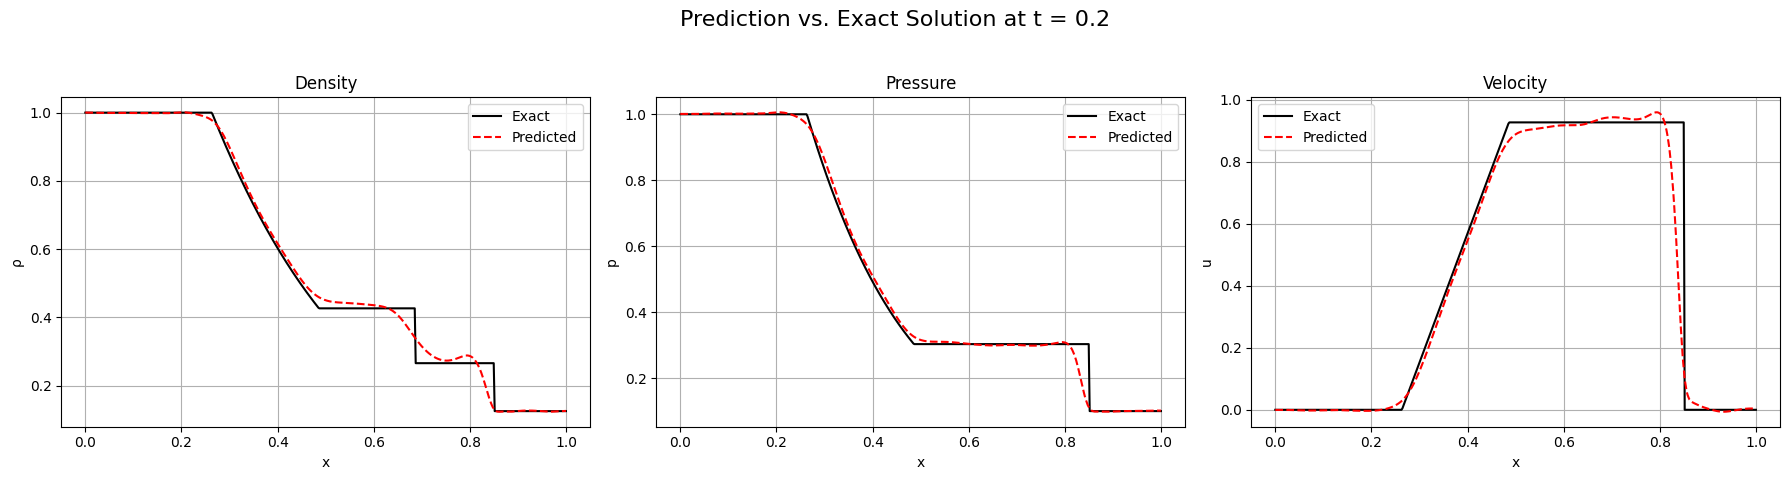

In [25]:
# --- Step 3: Evaluation and Analysis ---

# This function is used to convert torch tensors to numpy arrays for plotting
def to_numpy(input_tensor):
    if isinstance(input_tensor, torch.Tensor):
        return input_tensor.detach().cpu().numpy()
    elif isinstance(input_tensor, np.ndarray):
        return input_tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or np.ndarray')

print("\n--- Evaluating Final Model and Calculating L2 Error ---")
model.eval()
with torch.no_grad():
    u_pred_flat = to_numpy(model(x_test_tensor))

rho_pred_flat = u_pred_flat[:, 0]
p_pred_flat = u_pred_flat[:, 1]
u_pred_flat = u_pred_flat[:, 2]

# Reshape predictions to the 2D grid for plotting and error calculation at t=0.2
rho_pred_grid = rho_pred_flat.reshape(num_x, num_t)
p_pred_grid = p_pred_flat.reshape(num_x, num_t)
u_pred_grid = u_pred_flat.reshape(num_x, num_t)

rho_pred_t_final = rho_pred_grid[:, -1]
p_pred_t_final = p_pred_grid[:, -1]
u_pred_t_final = u_pred_grid[:, -1]

# --- Generate Exact Analytical Solution ---
left_state = (1., 1., 0.)
right_state = (0.1, 0.125, 0.)
npts = 500
solution_tuple = sodshock.solve(left_state=left_state, right_state=right_state,
                                geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=npts)

# Unpack the tuple and access the solution from the 'values' dictionary
positions, regions, values = solution_tuple
x_exact = values['x']
rho_exact = values['rho']
p_exact = values['p']
u_exact = values['u']

# --- Interpolate Predictions to Match Exact Solution Grid ---
rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

# --- Calculate Relative L2 Error ---
def relative_l2_error(pred, exact):
    return np.linalg.norm(pred - exact) / np.linalg.norm(exact)

error_rho = relative_l2_error(rho_pred_interp, rho_exact)
error_p = relative_l2_error(p_pred_interp, p_exact)
error_u = relative_l2_error(u_pred_interp, u_exact)

print("\n--- Final Results ---")
print(f"Relative L2 Error (Density): {error_rho:.4e}")
print(f"Relative L2 Error (Pressure): {error_p:.4e}")
print(f"Relative L2 Error (Velocity): {error_u:.4e}")

# --- Plot Comparison ---
plt.figure(figsize=(18, 5))
plt.suptitle('Prediction vs. Exact Solution at t = 0.2', fontsize=16)
plot_titles = ['Density', 'Pressure', 'Velocity']
y_labels = ['ρ', 'p', 'u']
exact_data = [rho_exact, p_exact, u_exact]
pred_data = [rho_pred_interp, p_pred_interp, u_pred_interp]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(x_exact, exact_data[i], 'k-', label='Exact')
    plt.plot(x_exact, pred_data[i], 'r--', label='Predicted')
    plt.title(plot_titles[i])
    plt.ylabel(y_labels[i])
    plt.xlabel('x')
    plt.grid(True)
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
# --- Experiment : Adjust Loss Weights ---

# --- Step 0: Install and Import Libraries ---
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# --- Step 1: Definitions and Setup ---
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Morlet(nn.Module):
    def __init__(self):
        super(Morlet, self).__init__()
    def forward(self, x):
        return torch.exp(-0.5 * x**2) * torch.cos(5 * x)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))
        self.net.add_module('Morlet_layer_1', Morlet())
        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))
            self.net.add_module('Morlet_layer_%d' % (num), Morlet())
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init, u_init, p_init = np.zeros((N)), np.zeros((N)), np.zeros((N))
    for i in range(N):
        if (x_coords[i] <= 0.5): rho_init[i], p_init[i] = 1.0, 1.0
        else: rho_init[i], p_init[i] = 0.125, 0.1
    return rho_init, u_init, p_init

def main():
    print(f"--- Running Experiment 3: Adjust Loss Weights ---")
    print(f"Using device: {device}")

    lr = 5e-4
    epochs = 80000

    # Data Generation
    num_x, num_t = 1000, 1000
    x_domain = np.linspace(-1.5, 3.125, num_x)
    t_domain = np.linspace(0, 0.2, num_t)
    t_grid, x_grid = np.meshgrid(t_domain, x_domain)
    T, X = t_grid.flatten()[:, None], x_grid.flatten()[:, None]
    x_test_tensor = torch.tensor(np.hstack((T, X)), dtype=torch.float32).to(device)

    num_i_train, num_f_train = 1000, 11000
    id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
    id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
    x_ic, t_ic = x_grid[id_ic, 0][:, None], t_grid[id_ic, 0][:, None]
    x_ic_train, (rho_ic_train, u_ic_train, p_ic_train) = np.hstack((t_ic, x_ic)), IC(x_ic)
    x_int, t_int = X[id_f, 0][:, None], T[id_f, 0][:, None]
    x_int_train = np.hstack((t_int, x_int))

    x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
    x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
    rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
    u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
    p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print('Start training...')
    tic = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(x_int_train_tensor)
            loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
            # --- LOSS WEIGHT CHANGE FOR THIS EXPERIMENT ---
            loss = 0.1 * loss_pde + 100.0 * loss_ic # Increased IC weight
            # ----------------------------------------------
            loss.backward()
            return loss, loss_pde, loss_ic
        loss, loss_pde, loss_ic = optimizer.step(closure)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f}')

    toc = time.time()
    print(f'Total training time: {toc - tic:.2f} seconds')

    # Evaluation
    print("\n--- Evaluating Final Model ---")
    model.eval()
    with torch.no_grad():
        u_pred_flat = model(x_test_tensor).cpu().numpy()
    rho_pred_t_final = u_pred_flat[:, 0].reshape(num_x, num_t)[:, -1]
    p_pred_t_final = u_pred_flat[:, 1].reshape(num_x, num_t)[:, -1]
    u_pred_t_final = u_pred_flat[:, 2].reshape(num_x, num_t)[:, -1]

    solution_tuple = sodshock.solve(left_state=(1., 1., 0.), right_state=(0.1, 0.125, 0.),
                                    geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=500)
    _, _, values = solution_tuple
    x_exact, rho_exact, p_exact, u_exact = values['x'], values['rho'], values['p'], values['u']

    rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
    p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
    u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

    def relative_l2_error(pred, exact): return np.linalg.norm(pred - exact) / np.linalg.norm(exact)
    error_rho = relative_l2_error(rho_pred_interp, rho_exact)
    error_p = relative_l2_error(p_pred_interp, p_exact)
    error_u = relative_l2_error(u_pred_interp, u_exact)

    print("\n--- Final Results ---")
    print(f"Relative L2 Error (Density): {error_rho:.4e}")
    print(f"Relative L2 Error (Pressure): {error_p:.4e}")
    print(f"Relative L2 Error (Velocity): {error_u:.4e}\n")

if __name__ == '__main__':
    main()

--- Running Experiment 3: Adjust Loss Weights ---
Using device: cuda
Start training...
Epoch 1000/80000 | Total Loss: 0.311194
Epoch 2000/80000 | Total Loss: 0.137630
Epoch 3000/80000 | Total Loss: 0.087260
Epoch 4000/80000 | Total Loss: 0.054447
Epoch 5000/80000 | Total Loss: 0.023610
Epoch 6000/80000 | Total Loss: 0.051375
Epoch 7000/80000 | Total Loss: 0.015113
Epoch 8000/80000 | Total Loss: 0.068025
Epoch 9000/80000 | Total Loss: 0.004141
Epoch 10000/80000 | Total Loss: 0.009346
Epoch 11000/80000 | Total Loss: 0.004147
Epoch 12000/80000 | Total Loss: 0.047903
Epoch 13000/80000 | Total Loss: 0.004081
Epoch 14000/80000 | Total Loss: 0.003564
Epoch 15000/80000 | Total Loss: 0.002079
Epoch 16000/80000 | Total Loss: 0.003080
Epoch 17000/80000 | Total Loss: 0.003392
Epoch 18000/80000 | Total Loss: 0.200583
Epoch 19000/80000 | Total Loss: 0.001472
Epoch 20000/80000 | Total Loss: 0.005015
Epoch 21000/80000 | Total Loss: 0.002859
Epoch 22000/80000 | Total Loss: 0.001384
Epoch 23000/80000 | 

e5

Using device: cuda
Start training with Complex Morlet Activation...
Epoch 1000/76140 | Total Loss: 107.949516 | PDE Loss: 97.10522461 | IC Loss: 1.08442926
Epoch 2000/76140 | Total Loss: 33.551094 | PDE Loss: 23.71162033 | IC Loss: 0.98394734
Epoch 3000/76140 | Total Loss: 16.897093 | PDE Loss: 7.60102320 | IC Loss: 0.92960691
Epoch 4000/76140 | Total Loss: 11.728439 | PDE Loss: 2.64229298 | IC Loss: 0.90861464
Epoch 5000/76140 | Total Loss: 10.094934 | PDE Loss: 1.23495579 | IC Loss: 0.88599789
Epoch 6000/76140 | Total Loss: 9.294975 | PDE Loss: 1.04942560 | IC Loss: 0.82455504
Epoch 7000/76140 | Total Loss: 8.676132 | PDE Loss: 1.21035826 | IC Loss: 0.74657738
Epoch 8000/76140 | Total Loss: 8.101199 | PDE Loss: 1.53010070 | IC Loss: 0.65710986
Epoch 9000/76140 | Total Loss: 7.164981 | PDE Loss: 1.63256907 | IC Loss: 0.55324113
Epoch 10000/76140 | Total Loss: 2.813001 | PDE Loss: 0.91443884 | IC Loss: 0.18985622
Saved model at epoch 10000
Epoch 11000/76140 | Total Loss: 1.160918 | PDE

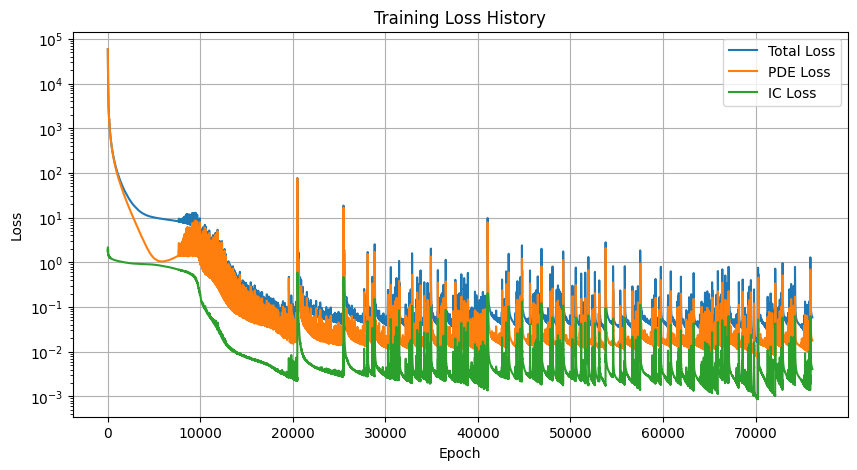


--- Evaluating Final Model and Calculating L2 Error ---
Solution type: <class 'tuple'>
Solution tuple length: 3
Element 0 type: <class 'dict'>
Element 0 keys: dict_keys(['Head of Rarefaction', 'Foot of Rarefaction', 'Contact Discontinuity', 'Shock'])
Element 1 type: <class 'dict'>
Element 1 keys: dict_keys(['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5'])
Element 2 type: <class 'dict'>
Element 2 keys: dict_keys(['x', 'p', 'rho', 'u', 'energy', 'rho_total'])

--- Final Results ---
Relative L2 Error (Density): 6.1620e-02
Relative L2 Error (Pressure): 4.4795e-02
Relative L2 Error (Velocity): 1.8328e-01


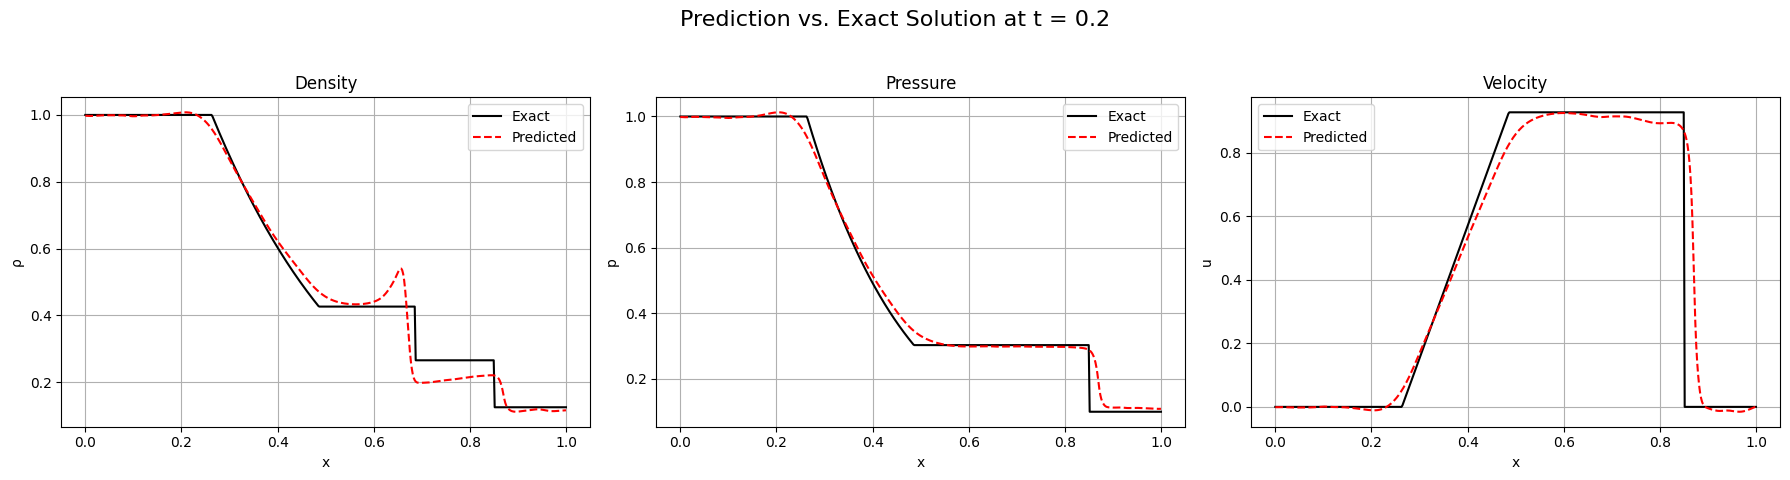

In [38]:
# Forward Problem for 1-D Euler Equations for Compressible Flow: The Sod Problem
# Modified Physics-Informed Neural Network with Complex Morlet Wavelet Activation
# + L2 Error Calculation
#
# Original Author: Alexandros D.L Papados
# Modifications:
# 1. Replaced Morlet activation with Complex Morlet wavelet (cos + sin terms).
# 2. Aligned PINN domain to [0, 1] to match sodshock geometry.
# 3. Adjusted loss weights for better PDE enforcement.
# 4. Added loss history tracking and learning rate scheduler.
# 5. Increased network capacity (50 neurons per layer).
# 6. Tuned Complex Morlet parameters (sigma=0.8, a=1.2, b=0.8).
# 7. Added model saving for intermediate analysis.

# --- Step 0: Install and Import Libraries ---
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
import os

# --- Step 1: Definitions and Setup ---
# Set seeds for reproducibility
torch.manual_seed(123456)
np.random.seed(123456)

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Complex Morlet Wavelet Activation
class ComplexMorlet(nn.Module):
    def __init__(self, sigma=0.8, omega=5.0, a=1.2, b=0.8):
        super(ComplexMorlet, self).__init__()
        self.sigma = sigma
        self.omega = omega
        self.a = a
        self.b = b

    def forward(self, x):
        gaussian = torch.exp(-0.5 * x**2 / self.sigma**2)
        oscillatory = self.a * torch.cos(self.omega * x) + self.b * torch.sin(self.omega * x)
        return gaussian * oscillatory

# Define Neural Network with Complex Morlet Activation
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 50))  # Increased neurons
        self.net.add_module('ComplexMorlet_layer_1', ComplexMorlet())
        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(50, 50))
            self.net.add_module('ComplexMorlet_layer_%d' % (num), ComplexMorlet())
        self.net.add_module('Linear_layer_final', nn.Linear(50, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init = np.zeros((x_coords.shape[0]))
    u_init = np.zeros((x_coords.shape[0]))
    p_init = np.zeros((x_coords.shape[0]))
    for i in range(N):
        if (x_coords[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1
    return rho_init, u_init, p_init

# --- Step 2: Data Generation and Model Training ---
# Parameters
lr = 0.0005
num_x = 1000
num_t = 1000
num_i_train = 1000
epochs = 76140  # Full training
num_f_train = 11000

# Create domain and test data
x_domain = np.linspace(0, 1, num_x)
t_domain = np.linspace(0, 0.2, num_t)
t_grid, x_grid = np.meshgrid(t_domain, x_domain)
T = t_grid.flatten()[:, None]
X = x_grid.flatten()[:, None]
x_test = np.hstack((T, X))
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

# Create training data
id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
x_ic = x_grid[id_ic, 0][:, None]
t_ic = t_grid[id_ic, 0][:, None]
x_ic_train = np.hstack((t_ic, x_ic))
rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)
x_int = X[id_f, 0][:, None]
t_int = T[id_f, 0][:, None]
x_int_train = np.hstack((t_int, x_int))

# Move training data to device
x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

# Initialize model and optimizer
model = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)

# Track loss history
loss_history = {'total': [], 'pde': [], 'ic': []}

# --- THE TRAINING LOOP ---
print('Start training with Complex Morlet Activation...')
tic = time.time()
for epoch in range(1, epochs + 1):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(x_int_train_tensor)
        loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
        loss = 1.0 * loss_pde + 10 * loss_ic  # Increased PDE weight
        loss.backward()
        return loss, loss_pde, loss_ic

    loss, loss_pde, loss_ic = optimizer.step(closure)
    scheduler.step()
    loss_history['total'].append(loss.item())
    loss_history['pde'].append(loss_pde.item())
    loss_history['ic'].append(loss_ic.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f} | '
              f'PDE Loss: {loss_pde.item():.8f} | IC Loss: {loss_ic.item():.8f}')

    # Save model every 10000 epochs
    if epoch % 10000 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
        print(f'Saved model at epoch {epoch}')

toc = time.time()
print(f'\nTotal training time: {toc - tic:.2f} seconds')
print("\n--- Training Complete. You can now run the next cell for analysis. ---")

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history['total'], label='Total Loss')
plt.plot(loss_history['pde'], label='PDE Loss')
plt.plot(loss_history['ic'], label='IC Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.savefig('loss_history.png')
plt.show()

# --- Step 3: Evaluation and Analysis ---
def to_numpy(input_tensor):
    if isinstance(input_tensor, torch.Tensor):
        return input_tensor.detach().cpu().numpy()
    elif isinstance(input_tensor, np.ndarray):
        return input_tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or np.ndarray')

print("\n--- Evaluating Final Model and Calculating L2 Error ---")
model.eval()
with torch.no_grad():
    u_pred_flat = to_numpy(model(x_test_tensor))

rho_pred_flat = u_pred_flat[:, 0]
p_pred_flat = u_pred_flat[:, 1]
u_pred_flat = u_pred_flat[:, 2]

# Reshape predictions to the 2D grid for plotting and error calculation at t=0.2
rho_pred_grid = rho_pred_flat.reshape(num_x, num_t)
p_pred_grid = p_pred_flat.reshape(num_x, num_t)
u_pred_grid = u_pred_flat.reshape(num_x, num_t)

rho_pred_t_final = rho_pred_grid[:, -1]
p_pred_t_final = p_pred_grid[:, -1]
u_pred_t_final = u_pred_grid[:, -1]

# --- Generate Exact Analytical Solution ---
left_state = (1., 1., 0.)
right_state = (0.1, 0.125, 0.)
npts = 500
solution_tuple = sodshock.solve(left_state=left_state, right_state=right_state,
                                geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=npts)

# Debug: Inspect solution structure
print("Solution type:", type(solution_tuple))
print("Solution tuple length:", len(solution_tuple))
for i, item in enumerate(solution_tuple):
    print(f"Element {i} type:", type(item))
    if isinstance(item, dict):
        print(f"Element {i} keys:", item.keys())

# Unpack the tuple and access the solution from the 'values' dictionary
try:
    positions, regions, values = solution_tuple
    x_exact = values['x']
    rho_exact = values['rho']
    p_exact = values['p']
    u_exact = values['u']
except Exception as e:
    print(f"Error unpacking solution: {e}")
    raise ValueError("Expected sodshock.solve to return a tuple (positions, regions, values) with values as a dictionary containing 'x', 'rho', 'p', 'u'.")

# Convert to NumPy arrays if not already
x_exact = to_numpy(x_exact)
rho_exact = to_numpy(rho_exact)
p_exact = to_numpy(p_exact)
u_exact = to_numpy(u_exact)

# --- Interpolate Predictions to Match Exact Solution Grid ---
rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

# --- Calculate Relative L2 Error ---
def relative_l2_error(pred, exact):
    return np.linalg.norm(pred - exact) / np.linalg.norm(exact)

error_rho = relative_l2_error(rho_pred_interp, rho_exact)
error_p = relative_l2_error(p_pred_interp, p_exact)
error_u = relative_l2_error(u_pred_interp, u_exact)

print("\n--- Final Results ---")
print(f"Relative L2 Error (Density): {error_rho:.4e}")
print(f"Relative L2 Error (Pressure): {error_p:.4e}")
print(f"Relative L2 Error (Velocity): {error_u:.4e}")

# --- Plot Comparison ---
plt.figure(figsize=(18, 5))
plt.suptitle('Prediction vs. Exact Solution at t = 0.2', fontsize=16)
plot_titles = ['Density', 'Pressure', 'Velocity']
y_labels = ['ρ', 'p', 'u']
exact_data = [rho_exact, p_exact, u_exact]
pred_data = [rho_pred_interp, p_pred_interp, u_pred_interp]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(x_exact, exact_data[i], 'k-', label='Exact')
    plt.plot(x_exact, pred_data[i], 'r--', label='Predicted')
    plt.title(plot_titles[i])
    plt.ylabel(y_labels[i])
    plt.xlabel('x')
    plt.grid(True)
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('solution_comparison.png')
plt.show()

Gaussian Wavelet Activation

In [1]:
# --- Experiment: Gaussian Wavelet ---
# --- Cell 1: Setup and Training ---

# Step 0: Install and Import Libraries
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# Step 1: Definitions and Setup
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running Experiment: Gaussian Wavelet Activation ---")
print(f"Using device: {device}")

# Define the Gaussian Wavelet activation function
class GaussianWavelet(nn.Module):
    def __init__(self):
        super(GaussianWavelet, self).__init__()
    def forward(self, x):
        return -x * torch.exp(-0.5 * x.pow(2))

# Define the DNN using the new activation
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))
        self.net.add_module('Gaussian_layer_1', GaussianWavelet())
        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))
            self.net.add_module('Gaussian_layer_%d' % (num), GaussianWavelet())
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init, u_init, p_init = np.zeros((N)), np.zeros((N)), np.zeros((N))
    for i in range(N):
        if (x_coords[i] <= 0.5): rho_init[i], p_init[i] = 1.0, 1.0
        else: rho_init[i], p_init[i] = 0.125, 0.1
    return rho_init, u_init, p_init

# Step 2: Data Generation and Model Training
lr = 0.0005
num_x, num_t = 1000, 1000
num_i_train, num_f_train = 1000, 11000
epochs = 77000

x_domain = np.linspace(-1.5, 3.125, num_x)
t_domain = np.linspace(0, 0.2, num_t)
t_grid, x_grid = np.meshgrid(t_domain, x_domain)
T, X = t_grid.flatten()[:, None], x_grid.flatten()[:, None]
x_test_tensor = torch.tensor(np.hstack((T, X)), dtype=torch.float32).to(device)

id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
x_ic, t_ic = x_grid[id_ic, 0][:, None], t_grid[id_ic, 0][:, None]
x_ic_train, (rho_ic_train, u_ic_train, p_ic_train) = np.hstack((t_ic, x_ic)), IC(x_ic)
x_int, t_int = X[id_f, 0][:, None], T[id_f, 0][:, None]
x_int_train = np.hstack((t_int, x_int))

x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print('Start training...')
tic = time.time()
for epoch in range(1, epochs + 1):
    model.train()
    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(x_int_train_tensor)
        loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
        loss = 0.1 * loss_pde + 10 * loss_ic
        loss.backward()
        return loss, loss_pde, loss_ic
    loss, loss_pde, loss_ic = optimizer.step(closure)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f}')
toc = time.time()
print(f'\nTotal training time: {toc - tic:.2f} seconds')
print("\n--- Training Complete. You can now run the next cell for analysis. ---")

Installing sodshock library...
--- Running Experiment: Gaussian Wavelet Activation ---
Using device: cuda
Start training...
Epoch 1000/77000 | Total Loss: 0.072062
Epoch 2000/77000 | Total Loss: 0.016214
Epoch 3000/77000 | Total Loss: 0.008730
Epoch 4000/77000 | Total Loss: 0.003465
Epoch 5000/77000 | Total Loss: 0.001472
Epoch 6000/77000 | Total Loss: 0.001286
Epoch 7000/77000 | Total Loss: 0.000993
Epoch 8000/77000 | Total Loss: 0.000909
Epoch 9000/77000 | Total Loss: 0.000802
Epoch 10000/77000 | Total Loss: 0.000734
Epoch 11000/77000 | Total Loss: 0.000639
Epoch 12000/77000 | Total Loss: 0.010428
Epoch 13000/77000 | Total Loss: 0.001322
Epoch 14000/77000 | Total Loss: 0.000847
Epoch 15000/77000 | Total Loss: 0.000705
Epoch 16000/77000 | Total Loss: 0.000615
Epoch 17000/77000 | Total Loss: 0.000564
Epoch 18000/77000 | Total Loss: 0.000550
Epoch 19000/77000 | Total Loss: 0.000450
Epoch 20000/77000 | Total Loss: 0.000396
Epoch 21000/77000 | Total Loss: 0.000363
Epoch 22000/77000 | Tota


--- Evaluating Final Model and Calculating L2 Error ---

--- Final Results (Gaussian Wavelet) ---
Relative L2 Error (Density): 2.7248e-02
Relative L2 Error (Pressure): 3.1126e-02
Relative L2 Error (Velocity): 1.0682e-01


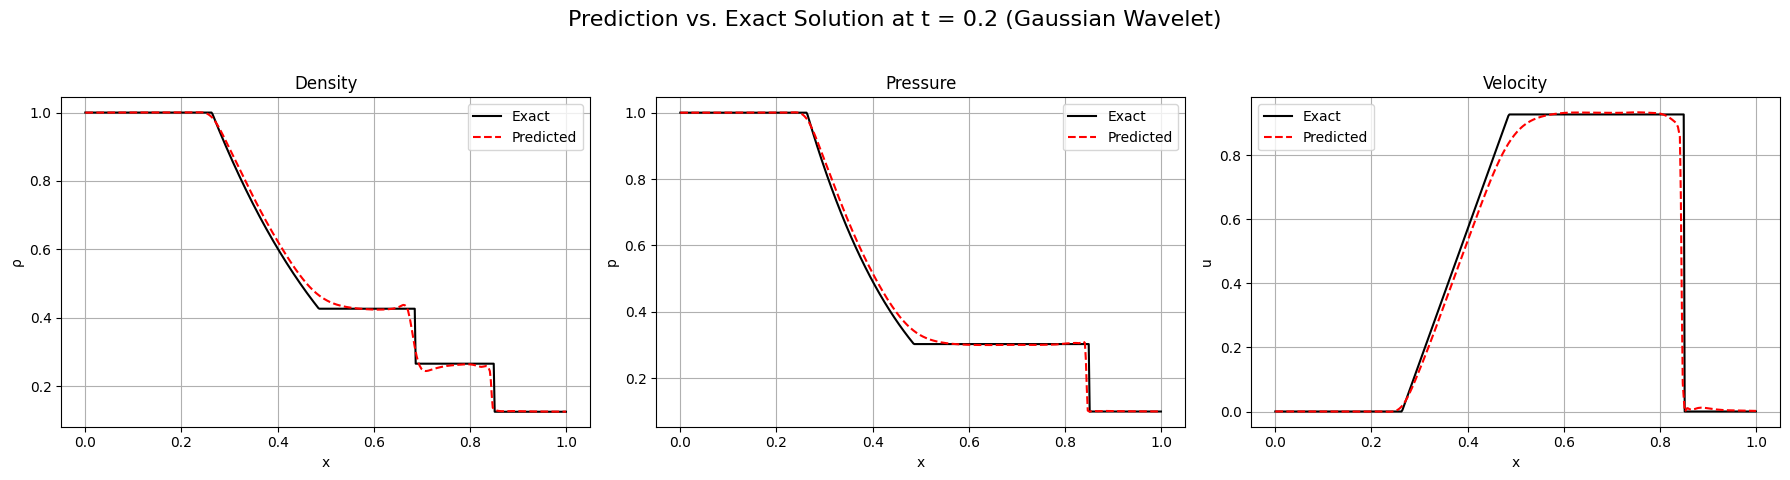

In [2]:
# --- Experiment: Gaussian Wavelet ---
# --- Cell 2: Evaluation and Analysis ---

def to_numpy(input_tensor):
    if isinstance(input_tensor, torch.Tensor):
        return input_tensor.detach().cpu().numpy()
    elif isinstance(input_tensor, np.ndarray):
        return input_tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or np.ndarray')

print("\n--- Evaluating Final Model and Calculating L2 Error ---")
model.eval()
with torch.no_grad():
    u_pred_flat = to_numpy(model(x_test_tensor))

rho_pred_flat = u_pred_flat[:, 0]
p_pred_flat = u_pred_flat[:, 1]
u_pred_flat = u_pred_flat[:, 2]

rho_pred_grid = rho_pred_flat.reshape(num_x, num_t)
p_pred_grid = p_pred_flat.reshape(num_x, num_t)
u_pred_grid = u_pred_flat.reshape(num_x, num_t)
rho_pred_t_final = rho_pred_grid[:, -1]
p_pred_t_final = p_pred_grid[:, -1]
u_pred_t_final = u_pred_grid[:, -1]

# Generate Exact Analytical Solution
left_state = (1., 1., 0.)
right_state = (0.1, 0.125, 0.)
npts = 500
solution_tuple = sodshock.solve(left_state=left_state, right_state=right_state,
                                geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=npts)
positions, regions, values = solution_tuple
x_exact, rho_exact, p_exact, u_exact = values['x'], values['rho'], values['p'], values['u']

# Interpolate Predictions
rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

# Calculate Relative L2 Error
def relative_l2_error(pred, exact):
    return np.linalg.norm(pred - exact) / np.linalg.norm(exact)

error_rho = relative_l2_error(rho_pred_interp, rho_exact)
error_p = relative_l2_error(p_pred_interp, p_exact)
error_u = relative_l2_error(u_pred_interp, u_exact)

print("\n--- Final Results (Gaussian Wavelet) ---")
print(f"Relative L2 Error (Density): {error_rho:.4e}")
print(f"Relative L2 Error (Pressure): {error_p:.4e}")
print(f"Relative L2 Error (Velocity): {error_u:.4e}")

# Plot Comparison
plt.figure(figsize=(18, 5))
plt.suptitle('Prediction vs. Exact Solution at t = 0.2 (Gaussian Wavelet)', fontsize=16)
plot_titles = ['Density', 'Pressure', 'Velocity']
y_labels = ['ρ', 'p', 'u']
exact_data = [rho_exact, p_exact, u_exact]
pred_data = [rho_pred_interp, p_pred_interp, u_pred_interp]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(x_exact, exact_data[i], 'k-', label='Exact')
    plt.plot(x_exact, pred_data[i], 'r--', label='Predicted')
    plt.title(plot_titles[i])
    plt.ylabel(y_labels[i])
    plt.xlabel('x')
    plt.grid(True)
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 Mexican Hat Wavelet Activation

In [3]:
# --- Experiment: Mexican Hat Wavelet ---
# --- Cell 1: Setup and Training ---

# Step 0: Install and Import Libraries
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# Step 1: Definitions and Setup
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running Experiment: Mexican Hat Wavelet Activation ---")
print(f"Using device: {device}")

# Define the Mexican Hat Wavelet activation function
class MexicanHatWavelet(nn.Module):
    """
    Mexican Hat Wavelet (2nd derivative of Gaussian) activation function.
    Formula: (1 - x^2) * exp(-0.5 * x^2)
    """
    def __init__(self):
        super(MexicanHatWavelet, self).__init__()
    def forward(self, x):
        return (1 - x.pow(2)) * torch.exp(-0.5 * x.pow(2))

# Define the DNN using the new activation
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))
        self.net.add_module('MexicanHat_layer_1', MexicanHatWavelet())
        for num in range(2, 7):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))
            self.net.add_module('MexicanHat_layer_%d' % (num), MexicanHatWavelet())
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init, u_init, p_init = np.zeros((N)), np.zeros((N)), np.zeros((N))
    for i in range(N):
        if (x_coords[i] <= 0.5): rho_init[i], p_init[i] = 1.0, 1.0
        else: rho_init[i], p_init[i] = 0.125, 0.1
    return rho_init, u_init, p_init

# Step 2: Data Generation and Model Training
lr = 0.0005
num_x, num_t = 1000, 1000
num_i_train, num_f_train = 1000, 11000
epochs = 77000

x_domain = np.linspace(-1.5, 3.125, num_x)
t_domain = np.linspace(0, 0.2, num_t)
t_grid, x_grid = np.meshgrid(t_domain, x_domain)
T, X = t_grid.flatten()[:, None], x_grid.flatten()[:, None]
x_test_tensor = torch.tensor(np.hstack((T, X)), dtype=torch.float32).to(device)

id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
x_ic, t_ic = x_grid[id_ic, 0][:, None], t_grid[id_ic, 0][:, None]
x_ic_train, (rho_ic_train, u_ic_train, p_ic_train) = np.hstack((t_ic, x_ic)), IC(x_ic)
x_int, t_int = X[id_f, 0][:, None], T[id_f, 0][:, None]
x_int_train = np.hstack((t_int, x_int))

x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print('Start training...')
tic = time.time()
for epoch in range(1, epochs + 1):
    model.train()
    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(x_int_train_tensor)
        loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
        loss = 0.1 * loss_pde + 10 * loss_ic
        loss.backward()
        return loss, loss_pde, loss_ic
    loss, loss_pde, loss_ic = optimizer.step(closure)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f}')
toc = time.time()
print(f'\nTotal training time: {toc - tic:.2f} seconds')
print("\n--- Training Complete. You can now run the next cell for analysis. ---")

--- Running Experiment: Mexican Hat Wavelet Activation ---
Using device: cuda
Start training...
Epoch 1000/77000 | Total Loss: 0.058591
Epoch 2000/77000 | Total Loss: 0.015471
Epoch 3000/77000 | Total Loss: 0.008831
Epoch 4000/77000 | Total Loss: 0.005105
Epoch 5000/77000 | Total Loss: 0.002866
Epoch 6000/77000 | Total Loss: 0.001417
Epoch 7000/77000 | Total Loss: 0.000964
Epoch 8000/77000 | Total Loss: 0.000766
Epoch 9000/77000 | Total Loss: 0.002073
Epoch 10000/77000 | Total Loss: 0.000565
Epoch 11000/77000 | Total Loss: 0.000560
Epoch 12000/77000 | Total Loss: 0.000686
Epoch 13000/77000 | Total Loss: 0.000405
Epoch 14000/77000 | Total Loss: 0.000326
Epoch 15000/77000 | Total Loss: 0.009105
Epoch 16000/77000 | Total Loss: 0.001767
Epoch 17000/77000 | Total Loss: 0.000971
Epoch 18000/77000 | Total Loss: 0.000748
Epoch 19000/77000 | Total Loss: 0.000573
Epoch 20000/77000 | Total Loss: 0.000393
Epoch 21000/77000 | Total Loss: 0.139636
Epoch 22000/77000 | Total Loss: 0.002951
Epoch 23000


--- Evaluating Final Model and Calculating L2 Error ---

--- Final Results (Mexican Hat Wavelet) ---
Relative L2 Error (Density): 2.0257e-02
Relative L2 Error (Pressure): 1.7911e-02
Relative L2 Error (Velocity): 5.1287e-02


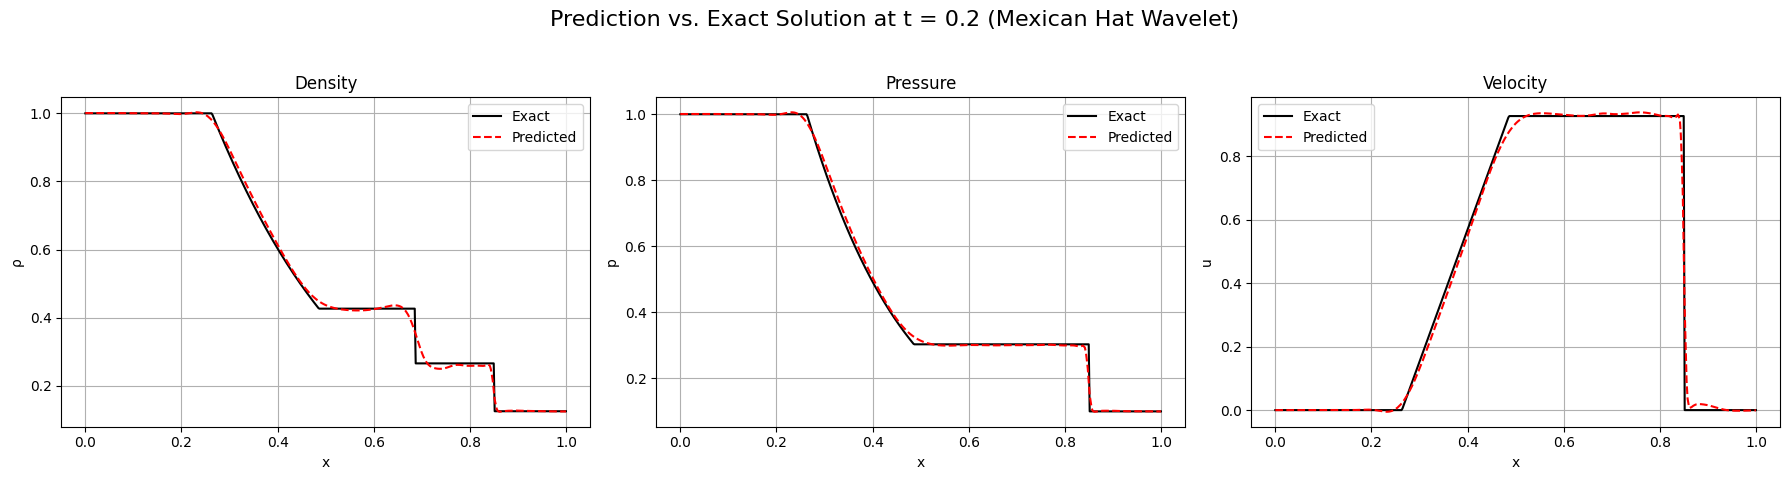

In [4]:
# --- Experiment: Mexican Hat Wavelet ---
# --- Cell 2: Evaluation and Analysis ---

def to_numpy(input_tensor):
    if isinstance(input_tensor, torch.Tensor):
        return input_tensor.detach().cpu().numpy()
    elif isinstance(input_tensor, np.ndarray):
        return input_tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or np.ndarray')

print("\n--- Evaluating Final Model and Calculating L2 Error ---")
model.eval()
with torch.no_grad():
    u_pred_flat = to_numpy(model(x_test_tensor))

rho_pred_flat = u_pred_flat[:, 0]
p_pred_flat = u_pred_flat[:, 1]
u_pred_flat = u_pred_flat[:, 2]

rho_pred_grid = rho_pred_flat.reshape(num_x, num_t)
p_pred_grid = p_pred_flat.reshape(num_x, num_t)
u_pred_grid = u_pred_flat.reshape(num_x, num_t)
rho_pred_t_final = rho_pred_grid[:, -1]
p_pred_t_final = p_pred_grid[:, -1]
u_pred_t_final = u_pred_grid[:, -1]

# Generate Exact Analytical Solution
left_state = (1., 1., 0.)
right_state = (0.1, 0.125, 0.)
npts = 500
solution_tuple = sodshock.solve(left_state=left_state, right_state=right_state,
                                geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=npts)
positions, regions, values = solution_tuple
x_exact, rho_exact, p_exact, u_exact = values['x'], values['rho'], values['p'], values['u']

# Interpolate Predictions
rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

# Calculate Relative L2 Error
def relative_l2_error(pred, exact):
    return np.linalg.norm(pred - exact) / np.linalg.norm(exact)

error_rho = relative_l2_error(rho_pred_interp, rho_exact)
error_p = relative_l2_error(p_pred_interp, p_exact)
error_u = relative_l2_error(u_pred_interp, u_exact)

print("\n--- Final Results (Mexican Hat Wavelet) ---")
print(f"Relative L2 Error (Density): {error_rho:.4e}")
print(f"Relative L2 Error (Pressure): {error_p:.4e}")
print(f"Relative L2 Error (Velocity): {error_u:.4e}")

# Plot Comparison
plt.figure(figsize=(18, 5))
plt.suptitle('Prediction vs. Exact Solution at t = 0.2 (Mexican Hat Wavelet)', fontsize=16)
plot_titles = ['Density', 'Pressure', 'Velocity']
y_labels = ['ρ', 'p', 'u']
exact_data = [rho_exact, p_exact, u_exact]
pred_data = [rho_pred_interp, p_pred_interp, u_pred_interp]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(x_exact, exact_data[i], 'k-', label='Exact')
    plt.plot(x_exact, pred_data[i], 'r--', label='Predicted')
    plt.title(plot_titles[i])
    plt.ylabel(y_labels[i])
    plt.xlabel('x')
    plt.grid(True)
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Wider network 77000

In [5]:
# --- Experiment 2: Wider Network ---

# --- Step 0: Install and Import Libraries ---
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# --- Step 1: Definitions and Setup ---
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Morlet(nn.Module):
    def __init__(self):
        super(Morlet, self).__init__()
    def forward(self, x):
        return torch.exp(-0.5 * x**2) * torch.cos(5 * x)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # --- ARCHITECTURE CHANGE FOR THIS EXPERIMENT ---
        NEURONS = 60 # Wider network
        LAYERS = 7
        # ---------------------------------------------
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, NEURONS))
        self.net.add_module('Morlet_layer_1', Morlet())
        for num in range(2, LAYERS):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(NEURONS, NEURONS))
            self.net.add_module('Morlet_layer_%d' % (num), Morlet())
        self.net.add_module('Linear_layer_final', nn.Linear(NEURONS, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init, u_init, p_init = np.zeros((N)), np.zeros((N)), np.zeros((N))
    for i in range(N):
        if (x_coords[i] <= 0.5): rho_init[i], p_init[i] = 1.0, 1.0
        else: rho_init[i], p_init[i] = 0.125, 0.1
    return rho_init, u_init, p_init

def main():
    print(f"--- Running Experiment 2: Wider Network ---")
    print(f"Using device: {device}")

    lr = 5e-4
    epochs = 77000

    # Data Generation
    num_x, num_t = 1000, 1000
    x_domain = np.linspace(-1.5, 3.125, num_x)
    t_domain = np.linspace(0, 0.2, num_t)
    t_grid, x_grid = np.meshgrid(t_domain, x_domain)
    T, X = t_grid.flatten()[:, None], x_grid.flatten()[:, None]
    x_test_tensor = torch.tensor(np.hstack((T, X)), dtype=torch.float32).to(device)

    num_i_train, num_f_train = 1000, 11000
    id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
    id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
    x_ic, t_ic = x_grid[id_ic, 0][:, None], t_grid[id_ic, 0][:, None]
    x_ic_train, (rho_ic_train, u_ic_train, p_ic_train) = np.hstack((t_ic, x_ic)), IC(x_ic)
    x_int, t_int = X[id_f, 0][:, None], T[id_f, 0][:, None]
    x_int_train = np.hstack((t_int, x_int))

    x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
    x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
    rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
    u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
    p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print('Start training...')
    tic = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(x_int_train_tensor)
            loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
            loss = 0.1 * loss_pde + 10 * loss_ic
            loss.backward()
            return loss, loss_pde, loss_ic
        loss, loss_pde, loss_ic = optimizer.step(closure)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f}')

    toc = time.time()
    print(f'Total training time: {toc - tic:.2f} seconds')

    # Evaluation
    print("\n--- Evaluating Final Model ---")
    model.eval()
    with torch.no_grad():
        u_pred_flat = model(x_test_tensor).cpu().numpy()
    rho_pred_t_final = u_pred_flat[:, 0].reshape(num_x, num_t)[:, -1]
    p_pred_t_final = u_pred_flat[:, 1].reshape(num_x, num_t)[:, -1]
    u_pred_t_final = u_pred_flat[:, 2].reshape(num_x, num_t)[:, -1]

    solution_tuple = sodshock.solve(left_state=(1., 1., 0.), right_state=(0.1, 0.125, 0.),
                                    geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=500)
    _, _, values = solution_tuple
    x_exact, rho_exact, p_exact, u_exact = values['x'], values['rho'], values['p'], values['u']

    rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
    p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
    u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

    def relative_l2_error(pred, exact): return np.linalg.norm(pred - exact) / np.linalg.norm(exact)
    error_rho = relative_l2_error(rho_pred_interp, rho_exact)
    error_p = relative_l2_error(p_pred_interp, p_exact)
    error_u = relative_l2_error(u_pred_interp, u_exact)

    print("\n--- Final Results ---")
    print(f"Relative L2 Error (Density): {error_rho:.4e}")
    print(f"Relative L2 Error (Pressure): {error_p:.4e}")
    print(f"Relative L2 Error (Velocity): {error_u:.4e}\n")

if __name__ == '__main__':
    main()

--- Running Experiment 2: Wider Network ---
Using device: cuda
Start training...
Epoch 1000/77000 | Total Loss: 0.074345
Epoch 2000/77000 | Total Loss: 0.035232
Epoch 3000/77000 | Total Loss: 0.035439
Epoch 4000/77000 | Total Loss: 0.012142
Epoch 5000/77000 | Total Loss: 0.007812
Epoch 6000/77000 | Total Loss: 0.010314
Epoch 7000/77000 | Total Loss: 0.005982
Epoch 8000/77000 | Total Loss: 0.008239
Epoch 9000/77000 | Total Loss: 0.013473
Epoch 10000/77000 | Total Loss: 0.003523
Epoch 11000/77000 | Total Loss: 0.001008
Epoch 12000/77000 | Total Loss: 0.011921
Epoch 13000/77000 | Total Loss: 0.001967
Epoch 14000/77000 | Total Loss: 0.001223
Epoch 15000/77000 | Total Loss: 0.010684
Epoch 16000/77000 | Total Loss: 0.000394
Epoch 17000/77000 | Total Loss: 0.004405
Epoch 18000/77000 | Total Loss: 0.014852
Epoch 19000/77000 | Total Loss: 0.001116
Epoch 20000/77000 | Total Loss: 0.000182
Epoch 21000/77000 | Total Loss: 0.006820
Epoch 22000/77000 | Total Loss: 0.020770
Epoch 23000/77000 | Total 

In [6]:
# ---  Experiment: Wider Mexican Hat Network ---

# --- Step 0: Install and Import Libraries ---
try:
    import sodshock
except ImportError:
    print("Installing sodshock library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sodshock"])
    import sodshock

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

# --- Step 1: Definitions and Setup ---
torch.manual_seed(123456)
np.random.seed(123456)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MexicanHatWavelet(nn.Module):
    """Mexican Hat Wavelet (2nd derivative of Gaussian) activation function."""
    def __init__(self):
        super(MexicanHatWavelet, self).__init__()
    def forward(self, x):
        return (1 - x.pow(2)) * torch.exp(-0.5 * x.pow(2))

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # --- CONFIGURATION FOR CHAMPION MODEL ---
        NEURONS = 60 # Using the wider network
        LAYERS = 7
        # ----------------------------------------
        self.net = nn.Sequential()
        self.net.add_module('Linear_layer_1', nn.Linear(2, NEURONS))
        self.net.add_module('MexicanHat_layer_1', MexicanHatWavelet())
        for num in range(2, LAYERS):
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(NEURONS, NEURONS))
            self.net.add_module('MexicanHat_layer_%d' % (num), MexicanHatWavelet())
        self.net.add_module('Linear_layer_final', nn.Linear(NEURONS, 3))

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)
        rho, p, u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        gamma = 1.4
        drho_g = gradients(rho, x)[0]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]
        du_g = gradients(u, x)[0]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]
        dp_g = gradients(p, x)[0]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]
        f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
            ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
            ((p_t + gamma*p*u_x + u*p_x)**2).mean()
        return f

    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)
        rho_ic_nn, p_ic_nn, u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
                   ((rho_ic_nn - rho_ic) ** 2).mean() + \
                   ((p_ic_nn - p_ic) ** 2).mean()
        return loss_ics

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def IC(x_coords):
    N = len(x_coords)
    rho_init, u_init, p_init = np.zeros((N)), np.zeros((N)), np.zeros((N))
    for i in range(N):
        if (x_coords[i] <= 0.5): rho_init[i], p_init[i] = 1.0, 1.0
        else: rho_init[i], p_init[i] = 0.125, 0.1
    return rho_init, u_init, p_init

def main():
    print(f"--- Running Final Champion Experiment ---")
    print("Activation: Mexican Hat, Architecture: 60 Neurons")
    print(f"Using device: {device}")

    # --- HYPERPARAMETERS FOR CHAMPION MODEL ---
    lr = 1e-4      # Using the lower, more stable learning rate
    epochs = 77000 # Full number of epochs
    # ------------------------------------------

    # Data Generation
    num_x, num_t = 1000, 1000
    x_domain = np.linspace(-1.5, 3.125, num_x)
    t_domain = np.linspace(0, 0.2, num_t)
    t_grid, x_grid = np.meshgrid(t_domain, x_domain)
    T, X = t_grid.flatten()[:, None], x_grid.flatten()[:, None]
    x_test_tensor = torch.tensor(np.hstack((T, X)), dtype=torch.float32).to(device)

    num_i_train, num_f_train = 1000, 11000
    id_ic = np.random.choice(x_domain.shape[0], num_i_train, replace=False)
    id_f = np.random.choice(x_domain.shape[0] * t_domain.shape[0], num_f_train, replace=False)
    x_ic, t_ic = x_grid[id_ic, 0][:, None], t_grid[id_ic, 0][:, None]
    x_ic_train, (rho_ic_train, u_ic_train, p_ic_train) = np.hstack((t_ic, x_ic)), IC(x_ic)
    x_int, t_int = X[id_f, 0][:, None], T[id_f, 0][:, None]
    x_int_train = np.hstack((t_int, x_int))

    x_ic_train_tensor = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
    x_int_train_tensor = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
    rho_ic_train_tensor = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
    u_ic_train_tensor = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
    p_ic_train_tensor = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print('Start training...')
    tic = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(x_int_train_tensor)
            loss_ic = model.loss_ic(x_ic_train_tensor, rho_ic_train_tensor, u_ic_train_tensor, p_ic_train_tensor)
            loss = 0.1 * loss_pde + 10 * loss_ic
            loss.backward()
            return loss, loss_pde, loss_ic
        loss, loss_pde, loss_ic = optimizer.step(closure)
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{epochs} | Total Loss: {loss.item():.6f}')

    toc = time.time()
    print(f'Total training time: {toc - tic:.2f} seconds')

    # Evaluation
    print("\n--- Evaluating Final Model ---")
    model.eval()
    with torch.no_grad():
        u_pred_flat = model(x_test_tensor).cpu().numpy()
    rho_pred_t_final = u_pred_flat[:, 0].reshape(num_x, num_t)[:, -1]
    p_pred_t_final = u_pred_flat[:, 1].reshape(num_x, num_t)[:, -1]
    u_pred_t_final = u_pred_flat[:, 2].reshape(num_x, num_t)[:, -1]

    solution_tuple = sodshock.solve(left_state=(1., 1., 0.), right_state=(0.1, 0.125, 0.),
                                    geometry=(0., 1., 0.5), t=0.2, gamma=1.4, npts=500)
    _, _, values = solution_tuple
    x_exact, rho_exact, p_exact, u_exact = values['x'], values['rho'], values['p'], values['u']

    rho_pred_interp = np.interp(x_exact, x_domain, rho_pred_t_final)
    p_pred_interp = np.interp(x_exact, x_domain, p_pred_t_final)
    u_pred_interp = np.interp(x_exact, x_domain, u_pred_t_final)

    def relative_l2_error(pred, exact): return np.linalg.norm(pred - exact) / np.linalg.norm(exact)
    error_rho = relative_l2_error(rho_pred_interp, rho_exact)
    error_p = relative_l2_error(p_pred_interp, p_exact)
    error_u = relative_l2_error(u_pred_interp, u_exact)

    print("\n--- Final Results ---")
    print(f"Relative L2 Error (Density): {error_rho:.4e}")
    print(f"Relative L2 Error (Pressure): {error_p:.4e}")
    print(f"Relative L2 Error (Velocity): {error_u:.4e}\n")

if __name__ == '__main__':
    main()

--- Running Final Champion Experiment ---
Activation: Mexican Hat, Architecture: 60 Neurons
Using device: cuda
Start training...
Epoch 1000/77000 | Total Loss: 0.100170
Epoch 2000/77000 | Total Loss: 0.034651
Epoch 3000/77000 | Total Loss: 0.017435
Epoch 4000/77000 | Total Loss: 0.011335
Epoch 5000/77000 | Total Loss: 0.007232
Epoch 6000/77000 | Total Loss: 0.004863
Epoch 7000/77000 | Total Loss: 0.001995
Epoch 8000/77000 | Total Loss: 0.001033
Epoch 9000/77000 | Total Loss: 0.000792
Epoch 10000/77000 | Total Loss: 0.000634
Epoch 11000/77000 | Total Loss: 0.000650
Epoch 12000/77000 | Total Loss: 0.000466
Epoch 13000/77000 | Total Loss: 0.000454
Epoch 14000/77000 | Total Loss: 0.000379
Epoch 15000/77000 | Total Loss: 0.000422
Epoch 16000/77000 | Total Loss: 0.000380
Epoch 17000/77000 | Total Loss: 0.000649
Epoch 18000/77000 | Total Loss: 0.000313
Epoch 19000/77000 | Total Loss: 0.000275
Epoch 20000/77000 | Total Loss: 0.000250
Epoch 21000/77000 | Total Loss: 0.000379
Epoch 22000/77000 |